---

# 4 Getting started with neural networks:

# Classification and regression

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 2  # nice scatter point size

from IPython.display import YouTubeVideo
from IPython.display import clear_output

from IPython.core.magic import register_cell_magic

import keras

os.environ["KERAS_BACKEND"] = "jax"

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

#### Binary classification: data → scalar (probability of *one* class)

*\"Here is a photo, is it a cat or not?" (Negative/Positive, detecting if something is there, etc.)*

#### Multiclass classification: data → vector (distribution over *many classes*)

*\"Here is a photo, multiple choice for you: is it a cat, a dog, an airplane, a flower, ... ?*

## * Regression: data → scalar (a continuous value describing the data)

*\"Here is a data about a house, what is its price)?* <small>☠️☠️☠️ *Logistic regression* (*classification problem*) ≠ *regression*!!</small>

---

# 4.3 Predicting house prices: A regression example

### 4.3.1 The California housing price dataset

The IMDB and Reuters (and MNIST) problems are examples of **classification**.

Decide a particular **class** from a finite number of possibilities.

They are **discrete** problems.

**Regression** problems, on the other hand, are **continuous**.

E.g. Predicting tomorrow's temperature, the time to run a marathon or...

1990s house prices in California.

Prices are continuous!

The [California Housing dataset](https://keras.io/api/datasets/california_housing/) ([source](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (down?), also on [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices), [scikit-learn](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)).

The aim is the prediction of the median house price on the basis of knowledge of income levels, rooms per dwelling, etc. (eight features in total).

There are two versions in Keras: `small` only 600 data samples, split into 480 training and 120 test; and `large` containing 20,640.

It is a good dataset to experiment with a **small amount** of data.

Furthermore, each feature has a **different scale**, a problem that we will need to address.

### Code: loading our dataset

In [2]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data(version="small")
print(train_data.shape, test_data.shape)

(480, 8) (120, 8)


### Examining our dataset

The first sample.

In [3]:
print(train_data[0])

[-1.2224e+02  3.7730e+01  2.1000e+01  7.0310e+03  1.2490e+03  2.9300e+03
  1.2350e+03  4.5213e+00]


The targets of the first ten samples in thousands of dollars.

In [4]:
train_targets[:10] # prices between $60,000 and $500,000 (ಥ﹏ಥ)

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100.], dtype=float32)

The 8 input features are the following:

- `longitude`: A measure of how far west a house is; a higher value is farther west
- `latitude`: A measure of how far north a house is; a higher value is farther north
- `medianAge`: Median age of a house within a block; a lower number is a newer building
- `totRooms`: Total number of rooms within a block
- `totBedrooms`: Total number of bedrooms within a block
- `population`: Total number of people residing within a block
- `households`: Total number of households, a group of people residing within a home unit, for a block
- `medianIncome`: Median income for households within a block of houses (measured in tens of thousands of US – multiply by `10_000`)

In [5]:
# See https://github.com/issues/created?issue=keras-team%7Ckeras%7C21886
column_names = [
    "longitude", "latitude", "medianAge",
    "totRooms", "totBedrooms", "population",
    "households", "medianIncome"
]

for name in column_names:
    print(f"{name:>14}", end="")
print()
print("-" * 112)
for row in range(20):
    for col in range(8):
        x = train_data[row, col]
        print(f"{x:14.4f}", end="")
    print()

     longitude      latitude     medianAge      totRooms   totBedrooms    population    households  medianIncome
----------------------------------------------------------------------------------------------------------------
     -122.2400       37.7300       21.0000     7031.0000     1249.0000     2930.0000     1235.0000        4.5213
     -122.2800       37.8500       48.0000     2063.0000      484.0000     1054.0000      466.0000        2.2625
     -122.2900       37.8200        2.0000      158.0000       43.0000       94.0000       57.0000        2.5625
     -122.2900       37.8100       46.0000      935.0000      297.0000      582.0000      277.0000        0.7286
     -122.1800       37.7600       37.0000     1575.0000      358.0000      933.0000      320.0000        2.2917
     -122.2300       37.7900       48.0000     1696.0000      396.0000     1481.0000      343.0000        2.0375
     -122.2800       37.8400       52.0000      729.0000      160.0000      395.0000      155.00

#### Standardisation / Normalisation

These ranges present difficulties.

Neural networks have difficulty adapting to heterogeneous data.

The data will have to be **standardised** / **normalised**.

Note: Chollet uses normalisation as an umbrella term, [as it often happens](https://en.wikipedia.org/wiki/Normalization_(statistics)).

---

## 4.3.1 Preparing the data

### Standardisation

- subtract the **mean** (= **average**);
- divide by the **standard deviation**.

What does this do?

It makes any distribution **centred** at zero, with a **standard deviation** of one.

The math...

$$
\bbox[5px,border:2px solid red]
{
{\frac {X-\mu }{\sigma }}
}
$$

$X$: our data  
$\mu$: the mean
$\sigma$: the standard deviation

### Normalisation

- subtract the **min value**;
- divide by the **range (max value - min value)**.

What does this do?

It squishes any distribution to a range of *\[0, 1\]*.

(We are not using this now.)

The math...

$$
\bbox[5px,border:2px solid red]
{
X'={\frac {X-X_{\min }}{X_{\max}-X_{\min }}}}
$$

$X$: our data   
$X_{\min }$: the min value in our data  
$X_{\max}$: the max value in our data  

### Compute stats on Train, apply those to Test

Test data is normalised using the mean and standard deviation of the *training* set.

In general, we want the **train** and **test** (and any further data) sets to come for the **same distribution**.

But we also want to keep our **test** aside, not get any influence from it.

Treat it as if was really data our net would encounter *in the wild*.

### Code: Normalization

In [6]:
# axis 0: along each feature axis!
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# shift & scale using the train statistics
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

In [7]:
y_train = train_targets / 100000
y_test = test_targets / 100000

#### Manual example

In [8]:
def stats(x):
    mean = sum(x) / len(x)                          # compute the mean
    deviations = x - mean                           # deviations can be positive or negative
    avg_sq_deviations = sum(deviations**2) / len(x) # we square them and take the mean
    std = np.sqrt(avg_sq_deviations)                # then we take the square root
    return mean, std

In [9]:
def normalise(x):
    mean, std = stats(x)
    return (x - mean) / std, mean, std # subtract the mean, divide by the standard deviation

#### Plotting normalized data

In [10]:
def plot_mean_std(nums):
    nums_norm, mean, std = normalise(nums)

    fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(16,3))

    ax1.bar([str(x) for x in range(nums.shape[0])], nums)                              # our numbers
    ax1.set_title(f"Original numbers | mean: {mean:.2f}, std: {std:.2f}")
    ax1.plot([mean] * nums.shape[0], linestyle='solid', color="r", label="mean")       # the mean
    ax1.plot([mean + std] * nums.shape[0], linestyle='dotted', color="r", label="std") # mean + std
    ax1.plot([mean - std] * nums.shape[0], linestyle='dotted', color="r")              # mean - std
    ax1.legend()

    ax2.bar([str(x) for x in range(nums_norm.shape[0])], nums_norm)                    # our numbers normalised
    ax2.set_title(f"Normalized | mean: {nums_norm.mean():.2f}, std: {nums_norm.std():.2f}")
    plt.show()

First example, 5 numbers. **Mean**: 30. **Standard deviation** : ~14.

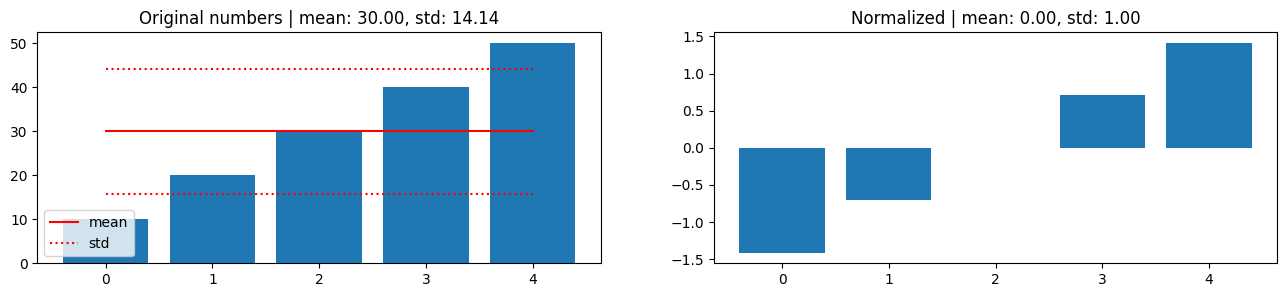

In [11]:
plot_mean_std(np.array([10.0, 20.0, 30.0, 40.0, 50.0]))

Second example, 5 numbers. **Mean**: 30. **Standard deviation** : ~20.

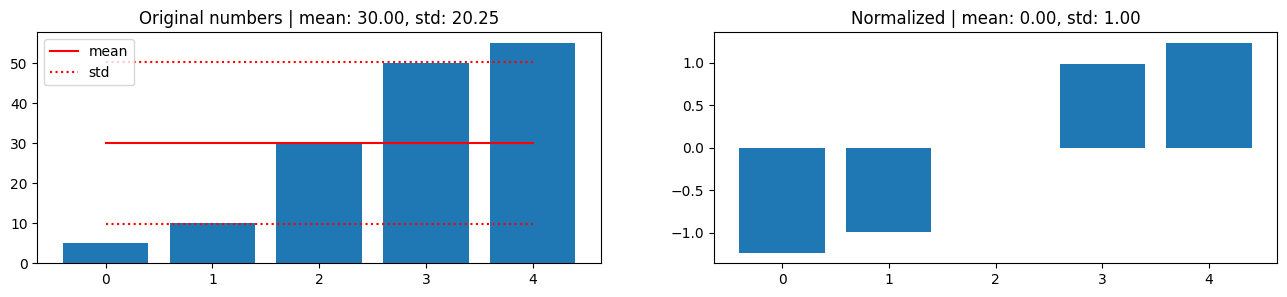

In [12]:
plot_mean_std(np.array([5.0, 10.0, 30.0, 50.0, 55.0]))

---

## 4.3.3 Building your model

We predict the value directly, therefore _no activation_ on the last layer.

### Loss: Mean squared error  (MSE)

A common regression **loss**:

$$
\bbox[5px,border:2px solid red]
{
\text{MSE} = \frac{1}{N} \sum (y_{pred} - y)^2
}
$$

$y$: target  
$y_{pred}$: network output  
$N$: mini-batch size

- continuous and differentiable;
- cost grows exponentially: outliers are penalised.

### Metric: Mean absolute error (MAE)

Our **metric** will be:

$$
\bbox[5px,border:2px solid red]
{
\text{MAE} = \frac{1}{N}\sum |y_{pred} - y |
}
$$

- nondifferentiable ([Keras will still allow you to use it as a loss...](https://stats.stackexchange.com/questions/312737/mean-absolute-error-mae-derivative));
- grows linearly: outliers are not more penalised.

### Plot MSE vs MAE

In [13]:
def plot_mse_mae():
    nums = np.linspace(-1.5,1.5, 100) # one hundred numbers from -10 to 10

    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(16,3))

    ax1.plot(nums, nums ** 2)                     # mean squared error (from zero)
    ax1.set_title("Mean squared error (MSE)")
    ax1.set_xlabel("distance from the mean")
    ax1.set_ylabel("loss")
    ax2.plot(nums, np.abs(nums))                  # mean absolute error (from zero)
    ax2.set_title(f"Mean absolute error (MAE)")
    ax2.set_xlabel("distance from the mean")
    ax2.set_ylabel("loss")
    plt.show()

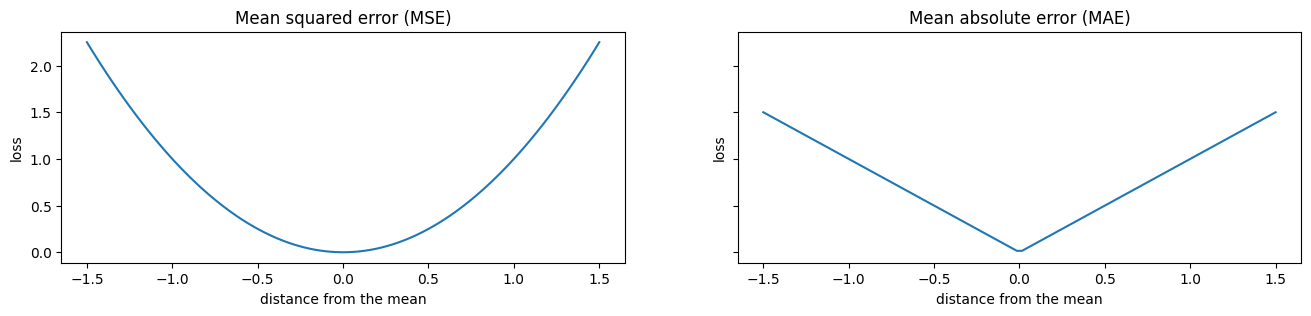

In [14]:
plot_mse_mae()

### Code: build the model

In [15]:
def build_model(clear=True): # modular programming!
    if clear:
        keras.backend.clear_session()
    model=keras.models.Sequential()
    model.add(keras.Input((x_train.shape[1],))),
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
            # ↓ NO ACTIVATION! We just predict (any) number
    model.add(keras.layers.Dense(1))
            # ↑ -------------------------------------------
    model.compile(
        optimizer='rmsprop',
        loss='mse',            # ← MSE: mean squared error
        metrics=['mae']        # ← MAE: mean absolute error
    )
    return model

---

## 4.3.4 Validating your approach using K-fold validation

### Techniques for very small datasets

The training set is **small** and if we split it to have a a validation set it will be even smaller.

(The validation set would be tiny.)

The validation scores – on a tiny validation set – would be very sensitive to the constitution of that set.

### $K$-fold cross-validation

A common solution for small datasets.

The data is spilt into $K$ partitions (usually 4 or 5).

$K$ identical models are instantiated.

One of the $K$s is validation, the rest is train.

We then rotate which partition is the validation.

A new network is trained and validated on each of these *fold*.

The validation score is the **average** of the $K$ validation scores.

This technique mitigates **validation variance**.

<!-- ![Chollet K-fold](images/chollet/figure4.9.png) -->

<img style="" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/03/images/chollet/figure4.9.png">

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter04_classification-and-regression/#validating-your-approach-using-k-fold-validation), Chapter 4, Figure 4.9</small>

### Before training: commonsense baseline / evaluate untrained model

#### Compute dataset statistics

What are the max, min, mean and variance of our test targets?

In [16]:
y_test_min, y_test_max = y_test.min(), y_test.max()
y_test_mean, y_test_std = y_test.mean(), y_test.std()
print(f"Test prices, min: {y_test_min:.4f} (~{y_test_min*100_000:,.0f}$) | max:  {y_test_max:.4f} (~{y_test_max*100_000:,.0f}$)")
print(f"Mean of our test prices: {y_test_mean:.4f} (~{int(y_test_mean)*100_000:,}$)")
print(f"STD of our test prices:  {y_test_std:.4f} (~{int(y_test_std)*100_000:,}$)")

Test prices, min: 0.7410 (~74,100$) | max:  5.0000 (~500,001$)
Mean of our test prices: 1.9616 (~100,000$)
STD of our test prices:  1.0152 (~100,000$)


#### Regression baseline: predicting the mean

What score do we get if we just predict the mean?

In [17]:
mean_prediction = []
y_test_mean = y_test.mean()
for test in y_test:                                     # a very plain loop!
    mean_prediction.append(np.abs(test - y_test_mean))  # MAE using the mean of our test dataset
mean_prediction_mae = np.array(mean_prediction).mean()
print(f"Predicting the mean of our test_set: {y_test_mean:.5f} (~{int(y_test_mean)*100_000:,.0f}$)")
print(f"MAE: {mean_prediction_mae:.4f} (~{mean_prediction_mae*100_000:,.0f}$)")

Predicting the mean of our test_set: 1.96155 (~100,000$)
MAE: 0.8280 (~82,797$)


#### 'Neural' baseline: our untrained model

In [18]:
test_mse_score, test_mae_score = build_model().evaluate(x_test, y_test, verbose=0)
test_mse_score_sqrt = np.sqrt(test_mse_score)
msg =  f"MSE: {test_mse_score:.4f}, sqrt: {test_mse_score_sqrt:.4f} "
msg += f"(~{round(test_mse_score_sqrt*1000):,}$) | "
msg += f"MAE: {test_mae_score:.4f} (~{test_mae_score*100_000:,.0f}$)"
print(msg)

MSE: 4.4191, sqrt: 2.1022 (~2,102$) | MAE: 1.8799 (~187,985$)


I0000 00:00:1765540364.101916  169239 service.cc:152] XLA service 0x600000581500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765540364.101936  169239 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1765540364.237656  169624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Code: Training with K-Fold validation

In [19]:
K = 4
num_val_samples = len(x_train) // K
num_epochs = 100
all_scores = []
all_mae_histories = []

for i in range(K):
    print(f"Processing fold {i+1}")
    
    # 1. Validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data, val_targets = x_train[a : b], y_train[a : b]

    # 2. Training data: data from all other partitions
    partial_x_train = np.concatenate([x_train[:a], x_train[b:]], axis=0)
    partial_y_train = np.concatenate([y_train[:a], y_train[b:]], axis=0)

    # 3. Build the Keras model (already compiled)
    model = build_model()

    # 4. Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_x_train, partial_y_train,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0
    )

    # 5. Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


### Code: Validation results

The fold MAE scores, and their range.

In [20]:
print(f"Validation MAE scores for each fold:")
for score in all_scores:
      print(f"{score:.4f} (~{score * 100_000:,.0f}$)")

Validation MAE scores for each fold:
0.3380 (~33,801$)
0.2789 (~27,893$)
0.2414 (~24,140$)
0.3188 (~31,883$)


In [21]:
min_score, max_score = min(all_scores), max(all_scores)
print(f"Validation MAE scores range from:")
print(f"{min_score:.4f} (~{min_score * 100_000:,.0f}$) to")
print(f"{max_score:.4f} (~{max_score * 100_000:,.0f}$)")

Validation MAE scores range from:
0.2414 (~24,140$) to
0.3380 (~33,801$)


The fold MAE scores mean.

In [22]:
val_mae_mean = np.mean(all_scores)
print(f"Validation MAE mean:")
print(f"{val_mae_mean:.4f} (~{val_mae_mean * 100_000:,.0f}$)")

Validation MAE mean:
0.2943 (~29,429$)


The average MAE is significant considering that the prices range from \\$60,000 to \\$500,000.

---

### Code: plotting results

In [23]:
# take the mean of all four folds for each epoch
average_mae_history = np.array(all_mae_histories).mean(axis=0)

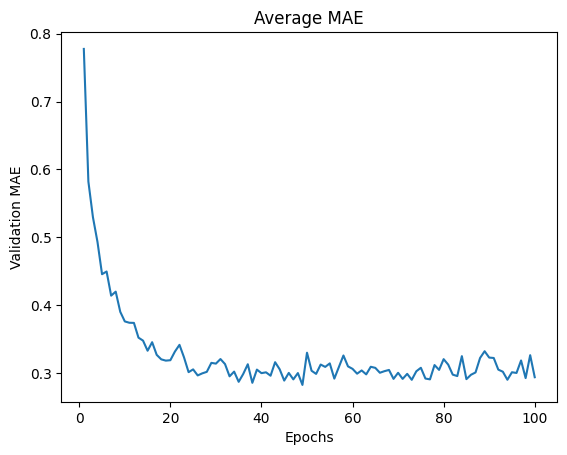

In [24]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Average MAE")
plt.show()

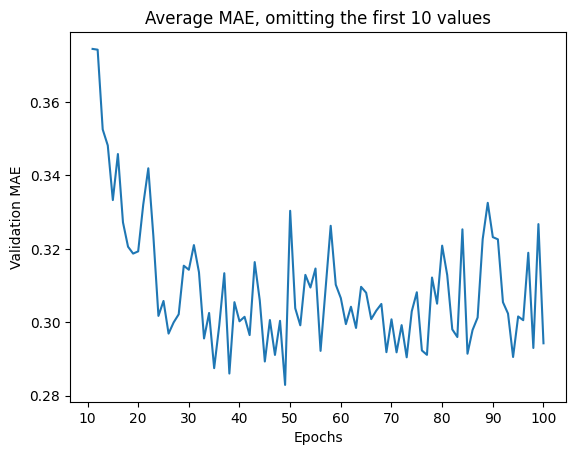

In [25]:
offset = 10
plt.plot(range(1, len(average_mae_history[offset:]) + 1), average_mae_history[offset:])

# adjust the ticks
step = 10
n = len(average_mae_history)
plt.xticks(range(0, n - offset + 1, step), range(offset, n + 1, step))

plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Average MAE, omitting the first 10 values")

plt.show()

### Code: automatic best epoch extraction 

Lowest MAE occurs at epoch...

In [26]:
# compare with smooth_mae_history
print(np.argmin(average_mae_history))

48


---

## Final model

We train a new model:
- on the whole training data
- until the epoch with lowest MAE

### Code: build and train with early stopping

In [27]:
model = build_model()
model.fit(
    x_train, # ← WHOLE TRAINING DATA
    y_train,
           # ↓ EPOCH WITH LOWEST MAE ----------
    epochs = np.argmin(average_mae_history) + 1,
           # ↑ --------------------------------
    batch_size = 16,
    verbose=0
)

### Code: evaluate on the test set, predict prices for random samples

In [28]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test, verbose=0)
test_mse_score_sqrt = np.sqrt(test_mse_score)
msg =  f"MSE: {test_mse_score:.4f}, sqrt: {test_mse_score_sqrt:.4f} "
msg += f"(~{round(test_mse_score_sqrt*100_000):,.0f}$) | "
msg += f"MAE: {test_mae_score:.4f} (~{test_mae_score*100_000:,.0f}$)"
print(msg)

MSE: 0.3032, sqrt: 0.5507 (~55,066$) | MAE: 0.2987 (~29,865$)


In [29]:
n = np.random.randint(x_test.shape[0])
pred_price = model.predict(x_test[n:n+1], verbose=0)[0,0]
print(f"Predicted price: ${pred_price * 100_000:.1f}")
print(f"Ground truth:    ${y_test[n]  * 100_000}")
print(f"Error:           ${abs(pred_price - y_test[n])  * 100_000:.1f}")

Predicted price: $298557.5
Ground truth:    $325900.0
Error:           $27342.5


---

## 4.3.6 Wrapping up

### Workflow

1. Prepare the data & split into Train/Validation/Test
2. Define your model
3. Evaluate your untrained model / a **commonsense baseline**
4. Train using **Train/Validation**
5. Tweak **hyperparameters** → pick best validation results
5. Evaluate on **Test**

### Summary

#### Inputs

- **Standardise/normalise** if the features are in different ranges;

##### Labels

- Just a number, meaning **no activation** in the last layer;

#### Key ideas

- **Do you know your data??**
- Overfitting;
- Commonsense baselines;
- K-fold validation (for small datasets);

### Regression

- We predict a **continuous value** (the price of a house);
- The final layer has **no activation**;
- The loss function is the **mean squared error**: `mse`;
- Instead of accuracy, use the **mean average error** `mae`;
- The model outputs the **desired output** (scaled).

### Experiments

- Run for more epochs and experiment with smoothing, like in [the book](https://deeplearningwithpython.io/chapters/chapter04_classification-and-regression/#validating-your-approach-using-k-fold-validation);
- More or fewer hidden layers – 32 units, 64 units etc.;
- Try different learning rates;
- Replace `relu` with an early neural network favourite, `tanh`;
- Try other [optimizers](https://keras.io/api/optimizers/), for instance `Adam`: `keras.optimizers.Adam(learning_rate=0.001)`